In [ ]:
import os
import librosa
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from glob import glob
import pickle

# Paths to folders
CHEER_FOLDER = "cheer"
NO_CHEER_FOLDER = "no_cheer"

# Load all audio files from folders
cheer_files = glob(os.path.join(CHEER_FOLDER, "*.wav"))
no_cheer_files = glob(os.path.join(NO_CHEER_FOLDER, "*.wav"))

# Assign labels (1 = Cheer, 0 = No Cheer)
file_paths = cheer_files + no_cheer_files
labels = [1] * len(cheer_files) + [0] * len(no_cheer_files)

# Function to extract features per second
def extract_features_per_second(file_path, segment_length=1.0):
    y, sr = librosa.load(file_path, sr=None)  # Load full audio
    features_list = []
    segment_samples = int(segment_length * sr)  # Convert seconds to samples

    # Split into 1-second segments
    for start in range(0, len(y), segment_samples):
        end = start + segment_samples
        segment = y[start:end]

        # If segment is shorter than 1 sec, pad with zeros
        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)))

        # Extract features
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(segment)

        # Combine features
        features = np.hstack([np.mean(mfcc, axis=1), np.mean(spectral_centroid), np.mean(zero_crossing_rate)])
        features_list.append(features)

    return np.array(features_list)

# Extract features for all files
X = np.array([extract_features_per_second(fp).mean(axis=0) for fp in file_paths])  # Averaging all segments
y = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print("Model Performance:\n", classification_report(y_test, y_pred))

# Function to classify each second of a test audio file
def predict_audio_segments(file_path, model, threshold=0.6):
    features_list = extract_features_per_second(file_path)  # Extract features per second
    y_probs = model.predict_proba(features_list)[:, 1]  # Get probability of "Cheer"

    # Classify each second based on threshold
    predictions = (y_probs >= threshold).astype(int)

    # Print results for each second
    print(f"\nResults for {file_path}:")
    for i, (prob, pred) in enumerate(zip(y_probs, predictions)):
        label = "Cheer" if pred == 1 else "No Cheer"
        print(f"Second {i+1}: {label} (Confidence: {prob:.2f})")

# Test on a new audio file
test_file = "highlights.wav"  # Replace with your actual test file
predict_audio_segments(test_file, rf_model)

# Save the model for future use
with open("cheer_detector_rf.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Model training complete and saved as 'cheer_detector_rf.pkl'")

Model Performance:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5


Results for highlights.wav:
Second 1: No Cheer (Confidence: 0.00)
Second 2: No Cheer (Confidence: 0.00)
Second 3: No Cheer (Confidence: 0.00)
Second 4: No Cheer (Confidence: 0.09)
Second 5: No Cheer (Confidence: 0.05)
Second 6: No Cheer (Confidence: 0.55)
Second 7: No Cheer (Confidence: 0.34)
Second 8: Cheer (Confidence: 0.73)
Second 9: Cheer (Confidence: 0.77)
Second 10: Cheer (Confidence: 0.74)
Second 11: No Cheer (Confidence: 0.36)
Second 12: No Cheer (Confidence: 0.10)
Second 13: No Cheer (Confidence: 0.11)
Second 14: Cheer (Confidence: 0.89)
Second 15: Cheer (Confidence: 0.78)
Second 16: Cheer (Confidence: 0.79)
Second 17: Cheer (Confidenc

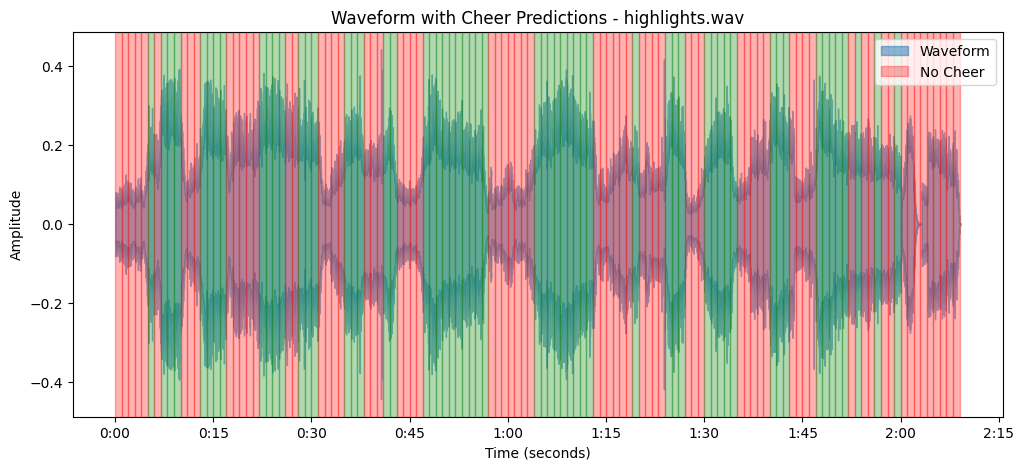

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_waveform_with_predictions(file_path, model, segment_length=1.0):
    # Load the full audio file
    y, sr = librosa.load(file_path, sr=None)

    # Split into segments of `segment_length` seconds
    segment_samples = int(segment_length * sr)
    num_segments = len(y) // segment_samples

    predictions = []
    time_stamps = []

    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        segment = y[start:end]

        # Extract features for this segment
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(segment)
        features = np.hstack([np.mean(mfcc, axis=1), np.mean(spectral_centroid), np.mean(zero_crossing_rate)])

        # Predict using trained model
        prediction = model.predict([features])[0]
        predictions.append(prediction)
        time_stamps.append(start / sr)  # Convert samples to seconds

    # Plot waveform
    plt.figure(figsize=(12, 5))
    librosa.display.waveshow(y, sr=sr, alpha=0.5, label="Waveform")

    # Overlay predictions as colored bars
    for i, t in enumerate(time_stamps):
        if predictions[i] == 1:
            plt.axvspan(t, t + segment_length, color='green', alpha=0.3, label="Cheer" if i == 0 else "")
        else:
            plt.axvspan(t, t + segment_length, color='red', alpha=0.3, label="No Cheer" if i == 0 else "")

    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform with Cheer Predictions - {file_path}")
    plt.legend()
    plt.show()

plot_waveform_with_predictions(test_file, rf_model)


In [ ]:
import subprocess
from moviepy.editor import VideoFileClip, concatenate_videoclips
from sklearn.ensemble import RandomForestClassifier

# Load trained model
MODEL_PATH = "/content/cheer_detector_rf.pkl"

with open(MODEL_PATH, "rb") as model_file:
    model = pickle.load(model_file)

  if event.key is 'enter':



In [ ]:
# Extract features from an audio segment
def extract_features(audio_segment, sr):
    mfcc = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=13)
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_segment, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_segment)
    features = np.hstack([np.mean(mfcc, axis=1), np.mean(spectral_centroid), np.mean(zero_crossing_rate)])
    return features

In [ ]:
# Process video file
def process_video(video_path, output_dir, segment_duration=2.0, cheer_threshold=0.6):
    audio_path = os.path.join(output_dir, "extracted_audio.wav")

    # Extract audio
    subprocess.run(["ffmpeg", "-i", video_path, "-q:a", "0", "-map", "a", audio_path, "-y"], check=True)

    # Load audio
    y, sr = librosa.load(audio_path, sr=16000)
    total_duration = librosa.get_duration(y=y, sr=sr)

    cheer_segments = []

    # Process each segment
    for start_time in np.arange(0, total_duration, segment_duration):
        end_time = min(start_time + segment_duration, total_duration)
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)
        segment = y[start_sample:end_sample]

        if len(segment) > 0:
            features = extract_features(segment, sr).reshape(1, -1)
            probability = model.predict_proba(features)[0][1]

            if probability >= cheer_threshold:
                cheer_segments.append((start_time, end_time))
    # Cut and merge clipsM
    cut_and_merge_clips(video_path, cheer_segments, output_dir)

In [ ]:
def merge_segments(segments, min_gap=2.0):
    """
    Merge overlapping or nearby segments into a single segment.
    """
    if not segments:
        return []

    # Sort segments by start time
    segments.sort()
    merged_segments = []
    current_start, current_end = segments[0]

    for start, end in segments[1:]:
        if start <= current_end + min_gap:  # Segments are close enough to merge
            current_end = max(current_end, end)  # Extend the current segment
        else:
            merged_segments.append((current_start, current_end))
            current_start, current_end = start, end

    # Add the last segment
    merged_segments.append((current_start, current_end))
    return merged_segments

In [ ]:
def cut_and_merge_clips(video_path, cheer_segments, output_dir):
    video = VideoFileClip(video_path)
    cheer_clips = []

    # Merge overlapping or nearby segments
    merged_segments = merge_segments(cheer_segments)

    for start, end in merged_segments:
        # Calculate the 10-second window around the detected cheer segment
        mid_point = (start + end) / 2
        clip_start = max(0, mid_point - 5)  # 5 seconds before the mid-point
        clip_end = min(video.duration, mid_point + 5)  # 5 seconds after the mid-point

        # Ensure the clip is exactly 10 seconds long
        if clip_end - clip_start < 10:
            if clip_start == 0:
                clip_end = min(video.duration, clip_start + 10)
            else:
                clip_start = max(0, clip_end - 10)

        clip = video.subclip(clip_start, clip_end)
        cheer_clips.append(clip)

    if cheer_clips:
        final_video = concatenate_videoclips(cheer_clips)
        output_video_path = os.path.join(output_dir, "highlight_reel.mp4")
        final_video.write_videofile(output_video_path, codec="libx264", fps=30)
        print(f"Final video saved at: {output_video_path}")
    else:
        print("No cheers detected.")

In [ ]:
video_file = "highlights.mp4"
output_directory = "output"
os.makedirs(output_directory, exist_ok=True)

process_video(video_file, output_directory)

Moviepy - Building video output/highlight_reel.mp4.
MoviePy - Writing audio in highlight_reelTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output/highlight_reel.mp4



Moviepy - Done !
Moviepy - video ready output/highlight_reel.mp4
Final video saved at: output/highlight_reel.mp4
